This notebook is similar to the notebook `alat_small_range/results/compare_errors.ipynb`.
That is, we compare the indicator configuration calculation results with the scale of the target error bars of the target QoI for the case of wide range of $\Delta a$.
Things we compare:
* Eigenvalues of the configurational FIM
* Parameter distributions
* Resulting uncertainty of the target QoI

In [1]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
from corner import corner

WORK_DIR = Path().absolute()

%matplotlib inline
plt.style.use("default")

# Load

In [2]:
# Intialize a main dictionary to store the results
results = {}

In [3]:
# This dictionary contains information to find the results from using different scale
# of error bars
directories = {
    10: WORK_DIR / "scale1" / "7",
    20: WORK_DIR / "scale2" / "7",
    30: WORK_DIR / "scale3" / "7",
    40: WORK_DIR / "scale4" / "7",
    50: WORK_DIR / "scale5" / "7",
    60: WORK_DIR / "scale6" / "7",
}
keys = directories.keys()

In [4]:
# Load FIM
for key, path in directories.items():
    filepath = path / "linearized_uq" / "jacobian_train.npy"
    jac = np.load(filepath)
    fim = jac.T @ jac
    results.update({key: {"fim": fim}})

In [5]:
# Load MCMC parameter samples
for key, path in directories.items():
    filepath = path / "mcmc" / "mcmc_result.pkl"
    mcmc = pickle.load(open(filepath, "rb"))
    chain = mcmc["chain"]
    samples = chain[0, :, 20_000::200].reshape((-1, 5))
    results[key].update({"samples": samples})
nsamples = len(samples)

In [6]:
# Load predictions ensembles
alist = np.arange(-1.0, 3.01, 0.05)
for key, path in directories.items():
    filepath = path / "mcmc" / "mcmc_target.npy"
    preds = np.load(filepath)[0].reshape((-1, len(alist) - 1))
    results[key].update({"predictions": preds})

# Plots

In [7]:
# These colors will be used to indicate the scale or target error bars in the plots.
# The first item of this list correspond to target error bars of 10% of the KIM's
# predictions. The size of the target error bars as we go to the right in the list.
colors = ["c", "m", "b", "r", "tab:green", "orange", "k"]

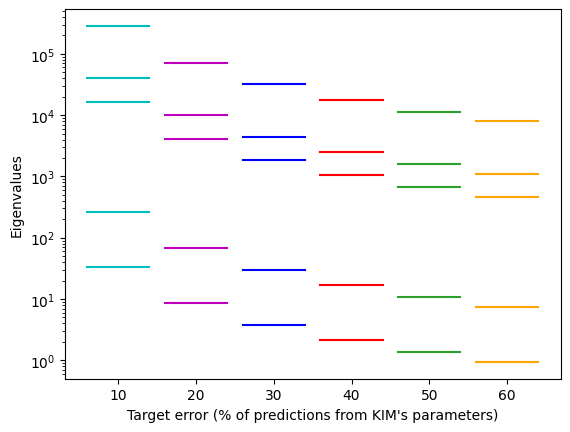

In [8]:
# Compare the eigenvalues of the FIM from the resulting indicator configurations
plt.figure()
for ii, key in enumerate(keys):
    lams = np.linalg.eigvalsh(results[key]["fim"])
    for ll in lams:
        plt.plot([ii - 0.4, ii + 0.4], [ll, ll], c=colors[ii])
plt.yscale("log")
plt.xticks(range(len(keys)), [f"{key}" for key in keys])
plt.xlabel("Target error (% of predictions from KIM's parameters)")
plt.ylabel("Eigenvalues")
plt.show()
plt.close()

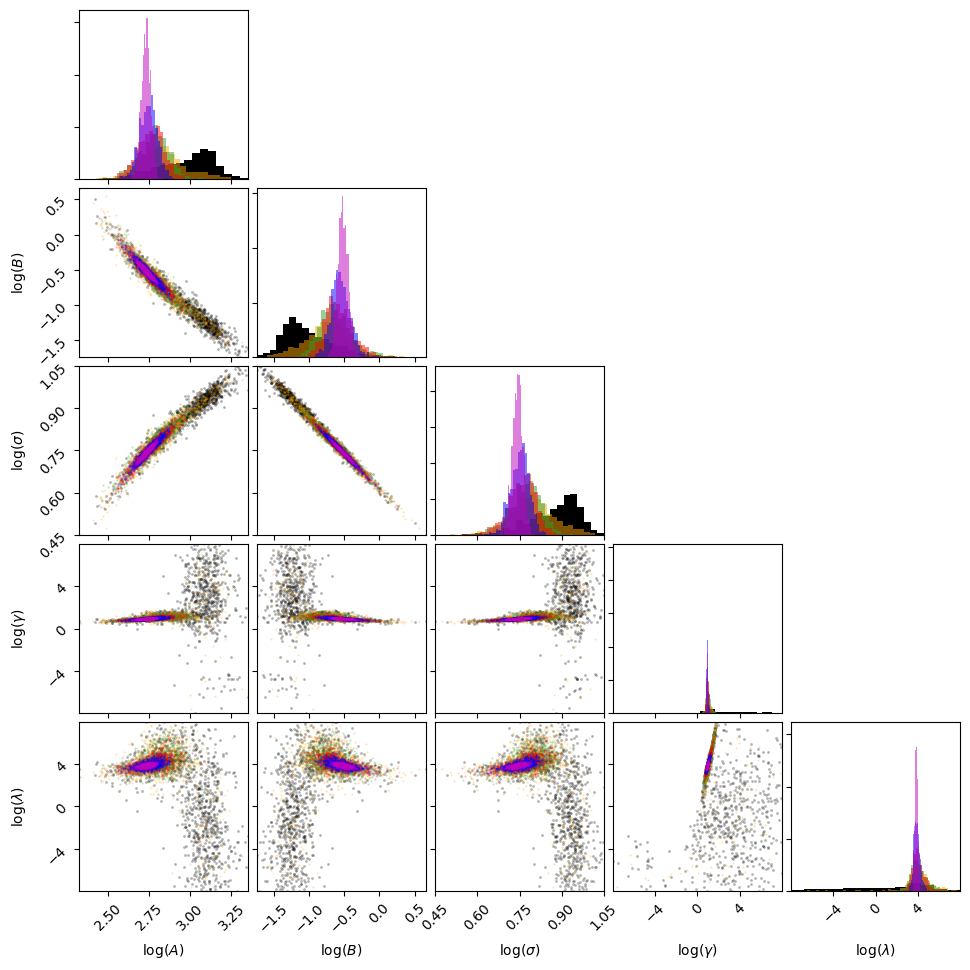

In [9]:
# Compare the MCMC samples
param_names = [
    r"$\log(A)$",
    r"$\log(B)$",
    r"$\log(\sigma)$",
    r"$\log(\gamma)$",
    r"$\log(\lambda)$",
]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for ii, key in enumerate(list(keys)[::-1]):
    samples = results[key]["samples"]
    cc = colors[::-1][ii]

    if ii == 0:
        bins = []
        max_hist = []
        for ss in samples.T:
            hist, _ = np.histogram(ss, bins="auto", density=True)
            max_hist.append(np.max(hist[0]))
            bins.append(len(hist))

        corner(
            samples,
            labels=param_names,
            bins=bins,
            fig=fig,
            hist_kwargs=dict(color=cc, density=True, histtype="stepfilled"),
            **dict(
                color=cc,
                plot_contours=False,
                plot_density=False,
                data_kwargs=dict(alpha=0.3),
            ),
        )

    else:
        for row in range(5):
            for col in range(row + 1):
                ax = axes[row, col]
                if col < row:
                    ax.plot(*(samples[:, [col, row]].T), ".", c=cc, ms=1, alpha=0.3)
                else:
                    hist, _, _ = ax.hist(
                        samples[:, col], bins="auto", density=True, color=cc, alpha=0.5
                    )
                    if np.max(hist) > max_hist[col]:
                        max_hist[col] = np.max(hist)

    # Update the axis heights on the diagonal
    for col in range(5):
        axes[col, col].set_ylim(top=max_hist[col] * 1.05)

plt.show()
plt.close()

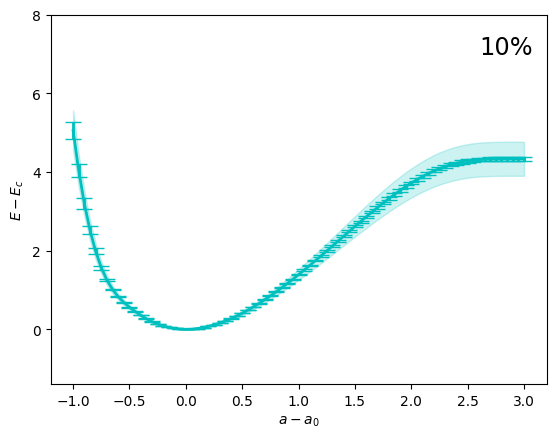

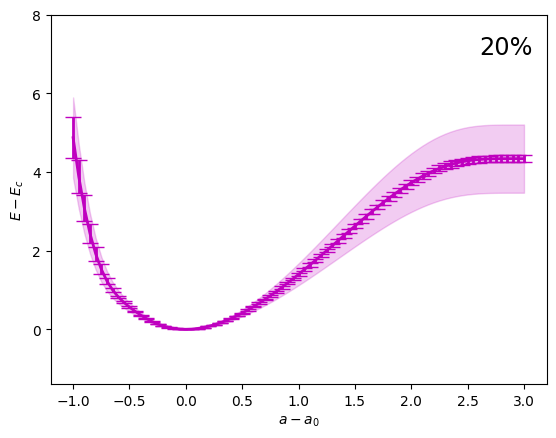

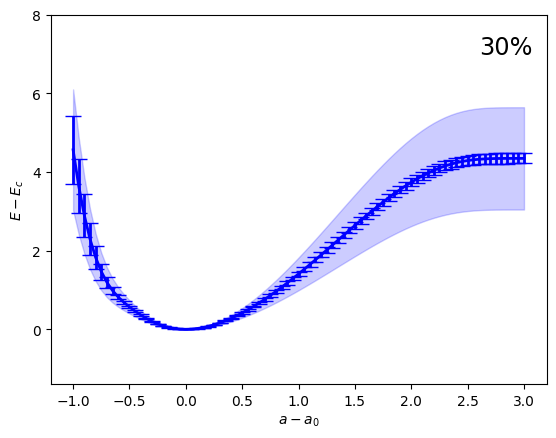

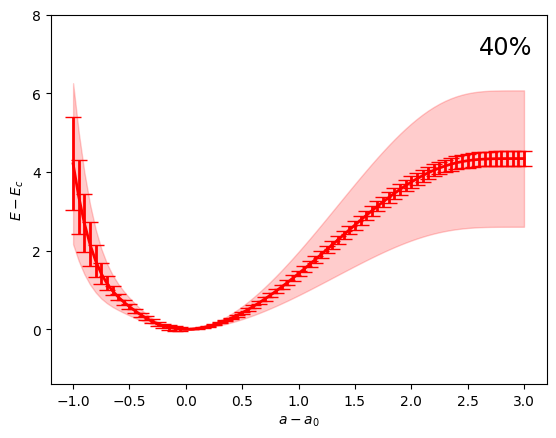

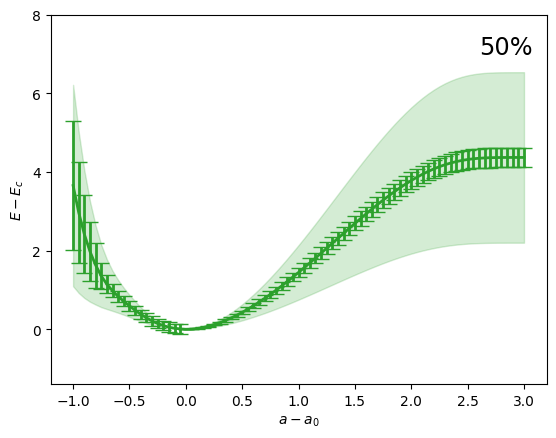

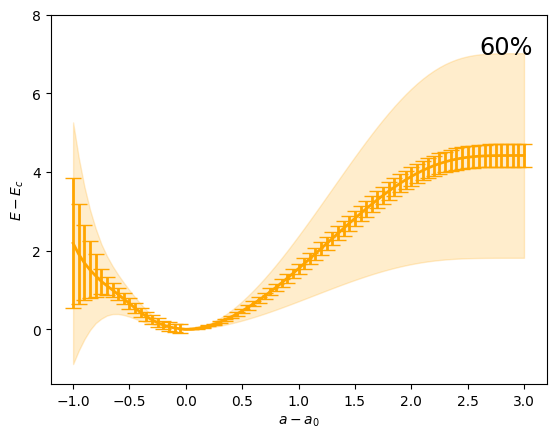

In [10]:
# Compare the propagated uncertainty of the target QoI
err_base = np.load(WORK_DIR.parent / "energycurve_data.npz")["error"]

for ii, key in enumerate(keys):
    plt.figure()
    err_target = err_base * 0.1 * key

    preds = results[key]["predictions"]
    mean = np.insert(np.mean(preds, axis=0), 20, 0.0)
    err = np.insert(np.std(preds, axis=0), 20, 0.0)

    plt.fill_between(
        alist,
        mean - err_target,
        mean + err_target,
        color=colors[ii],
        alpha=0.2,
        label="target",
    )
    plt.errorbar(alist, mean, err, c=colors[ii], lw=2, capsize=6)

    plt.ylim(-1.4, 8.0)
    plt.xlabel(r"$a-a_0$")
    plt.ylabel(r"$E-E_c$")
    plt.text(2.6, 7.0, f"{key}%", fontsize="xx-large")
    # plt.legend()

plt.show()
plt.close()